# Multi-Agent Collaboration and Orchestration using LangGraph for Mistral Models

## Introduction

This notebook demonstrates a sophisticated multi-agent system built with LangGraph and powered by Mistral. This Multi-Agent City Information System provides comprehensive information about a city, including events, weather, activities, and recommendations.

## Goals and Expected Outcomes

This notebook aims to demonstrate and achieve the following:

1. Integration and Orchestration:
   - Showcase the integration of Mistral for building complex LLM applications.
   - Demonstrate the power of LangGraph in creating and orchestrating multi-agent systems.
   - Illustrate the integration of various data sources and APIs within a multi-agent framework.

2. Comprehensive City Information System:
   Create a multi-agent system that delivers:
   - Upcoming events information:
     * Retrieved from a local SQLite database
     * Searched online using the Tavily API when local data is unavailable
   - Current weather information and analysis using the OpenWeatherMap API
   - Suggested activities based on events and weather conditions
   - Outfit recommendations considering the weather

3. System Flexibility and Adaptability:
   - Demonstrate the system's ability to handle varying levels of available information across different cities.
   - Showcase the seamless switching between local and online data sources.

4. Analysis and Synthesis:
   - Provide a final analysis that combines event and weather information into coherent and useful recommendations for city visitors or residents.

## Benefits of Using Multi-Agents

- **Modularity**: Each agent focuses on a specific task, making the system easier to maintain and extend.
- **Flexibility**: Agents can be easily added, removed, or modified without affecting the entire system.
- **Scalability**: The system can handle complex workflows by distributing tasks among multiple agents.
- **Improved Performance**: Parallel processing of tasks by different agents can lead to faster results.
- **Specialization**: Each agent can be optimized for its specific task, improving overall system efficiency.

## Why Use LangGraph?

LangGraph is a powerful framework for building multi-agent systems:

- Provide a structured way to define and manage the flow of information between agents.
- Offer built-in support for state management and checkpointing.
- Allow for easy visualization of the agent workflow.
- Integrate well with large language models and other AI tools.
- Support conditional routing, enabling dynamic workflow adjustments based on intermediate results.

## System Components

Our multi-agent system consists of the following components:

1. **EventsDB Tool**: Queries a local SQLite database for event information.
2. **Search Tool**: Utilizes the Tavily API to search for online event information when local data is unavailable.
3. **Weather Tool**: Fetches current weather data using the OpenWeatherMap API.
4. **Analysis Node**: Synthesizes information from other agents to provide comprehensive recommendations.

## Key Technologies Used

- **Mistral API**: For accessing the Mistral large language model
- **Cohere API**: To generate text embeddings of restraunts data
- **LangGraph**: For orchestrating the multi-agent system
- **Langchain**: For building the RAG pipeline and other LLM interactions
- **SQLite**: For local event database storage
- **Tavily API**: For online event searches
- **OpenWeatherMap API**: For current weather data

By the end of this notebook, you'll have a clear understanding of how to build a sophisticated multi-agent system that can process and synthesize information from various sources, adapting to different scenarios and data availability to provide valuable insights about a city.


## Environment Setup

 You'll also need to install the required Python libraries.


In [110]:
# Install all the required packages, including openai for embeddings
%pip install --upgrade --no-cache-dir --force-reinstall \
    faiss-cpu \
    ipython \
    langchain \
    langchain-community \
    langgraph \
    pandas \
    pydantic \
    pyowm \
    requests \
    tavily-python


   ---------------------------------------- 0.0/15.0 MB ? eta -:--:--
   -------------- ------------------------- 5.5/15.0 MB 30.5 MB/s eta 0:00:01
   -------------------------------------- - 14.4/15.0 MB 36.3 MB/s eta 0:00:01
   ---------------------------------------- 15.0/15.0 MB 34.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/604.3 kB ? eta -:--:--
   ---------------------------------------- 604.3/604.3 kB ? eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 24.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 2.5/2.5 MB 73.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   -------------------------------- ------- 9.4/11.5 MB 45.2 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 40.0 MB/s eta 0:00:00
   ----------------------------

  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\project1\\.venv\\lib\\site-packages\\numpy\\_core\\tests\\test_multithreading.py'
Check the permissions.


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
%pip install -q mistralai python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import langgraph.prebuilt as lp
print(dir(lp))             # see what’s in prebuilt
import pkgutil
print([m.name for m in pkgutil.iter_modules(lp.__path__)])


['InjectedState', 'InjectedStore', 'ToolNode', 'ValidationNode', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'chat_agent_executor', 'create_react_agent', 'tool_node', 'tool_validator', 'tools_condition']
['chat_agent_executor', 'interrupt', 'tool_node', 'tool_validator']


In [ ]:
# LangGraph imports
from langgraph.graph import StateGraph, END

# Attempt old import, fall back to the new ToolNode
try:
    from langgraph.prebuilt import ToolInvocation
except ImportError:
    from langgraph.prebuilt.tool_node import ToolNode as ToolInvocation

from langgraph.checkpoint.memory import MemorySaver


In [ ]:
# %% [markdown]
# ## Environment Setup
# Tags: setup

from dotenv import load_dotenv
load_dotenv()  # Loads from .env

True

## Setup and Requirements

Sign up for the following API keys as they will be used by the agents throughout this notebook:

a. **Tavily Search API** is used for performing web searches to find up-to-date information about events in various cities.
: 
   - Visit [Tavily AI](https://tavily.com/) and sign up for an account.
   - Once registered, navigate to your dashboard to find your API key.
   - Set the environment variable `TAVILY_API_KEY` with your Tavily API key.

b. **OpenWeatherMap API** provides current weather data for cities worldwide, which is used in our weather analysis.

   - Go to [OpenWeatherMap](https://openweathermap.org/) and create an account.
   - After signing up, go to your account dashboard and find your API key.
   - Set the environment variable `OPENWEATHERMAP_API_KEY` with your OpenWeatherMap API key.

c. **Mistal API** 

   - Tool Execution: Forces tool calls (tool_choice) for agents (e.g., search_tool, weather_tool).
   - Free-Tier Optimization: Uses mistral-tiny with max_tokens=300-600 to stay within limits.
   - Analysis Agent: Generates summaries using structured prompts (weather, events, restaurants).
   - State Management: Processes JSON responses to update State (e.g., state.analysis_result).
   - Set the environment variable `MISTRAL_API_KEY` with your Mistral API key.

d. **Cohere API**
   - Embeddings: Powers FAISS vector store via CohereEmbeddings (e.g., embed-english-v3.0).
   - RAG Queries: Retrieves restaurant data using similarity search (filter={"stars": {"$gte": 4}}).
   - Model Choice: Uses lightweight models (embed-english-light-v2.0) for free-tier efficiency.
   - Set the environment variable `COHERE_API_KEY` with your Cohere API key.

Now, let's import the necessary libraries and set up our environment:

In [ ]:
# %% [markdown]
# ## Mistral API Integration (Verified Working)
# Tags: api, mistral

import requests
import os
from typing import List, Dict

def call_mistral_api(
    messages: List[Dict[str, str]],
    model: str = "mistral-tiny",  # Free tier default
    temperature: float = 0.7,
    max_tokens: int = 1000
) -> Dict:
    """
    Working implementation for Mistral's API endpoint:
    POST https://api.mistral.ai/v1/chat/completions
    
    Returns:
        Dict: API response containing:
        - choices: [{"message": {"content": "response text"}}]
        - usage: {"total_tokens": int}
    """
    endpoint = "https://api.mistral.ai/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {os.getenv('MISTRAL_API_KEY')}",
        "Content-Type": "application/json",
        "Accept": "application/json"
    }
    payload = {
        "model": model,
        "messages": messages,
        "temperature": temperature,
        "max_tokens": max_tokens
    }
    
    try:
        response = requests.post(endpoint, json=payload, headers=headers, timeout=30)
        response.raise_for_status()  # Raises HTTPError for bad responses
        return response.json()
    except requests.exceptions.RequestException as e:
        error_msg = f"Mistral API Error: {str(e)}"
        if hasattr(e, 'response') and e.response:
            error_msg += f"\nResponse: {e.response.text}"
        raise RuntimeError(error_msg)

In [ ]:
%pip install -q langchain-cohere cohere
from langchain_cohere import CohereEmbeddings

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# %% [markdown]
# ## Core Setup Cell
# Tags: initialization, imports

# Standard library imports
import json
import logging
import os
import sys
import traceback
from datetime import datetime
from typing import List, Dict

# Third-party imports
import pandas as pd
import sqlite3
import requests
from IPython.display import Image, display
from pydantic import BaseModel, Field
from tavily import TavilyClient
import cohere

# LangChain imports
from langchain.docstore.document import Document
from langchain.vectorstores import FAISS
from langchain_cohere import CohereEmbeddings, ChatCohere  # Changed from OpenAI
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_text_splitters import RecursiveJsonSplitter

# LangGraph imports
from langgraph.graph import StateGraph, END
try:
    from langgraph.prebuilt import ToolInvocation
except ImportError:
    from langgraph.prebuilt.tool_node import ToolNode as ToolInvocation
from langgraph.checkpoint.memory import MemorySaver

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    stream=sys.stdout,
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# Environment variables (Moved to .env - these are just examples)
os.environ["COHERE_API_KEY"] = ""  # Replace with real key or use .env
os.environ["MISTRAL_API_KEY"] = ""
os.environ["OPENWEATHERMAP_API_KEY"] = ""
os.environ["TAVILY_API_KEY"] = ""

# Constants
DEFAULT_MODEL = "mistral-tiny"  # Free tier model
EMBEDDINGS_MODEL = CohereEmbeddings(
    model="embed-english-v3.0",
    truncate="END"  # Handles long texts
)

def call_mistral_api1(
    messages: List[Dict[str, str]],
    model: str = DEFAULT_MODEL
) -> Dict:
    """Enhanced Mistral API call with error handling"""
    try:
        resp = requests.post(
            "https://api.mistral.ai/v1/chat/completions",
            json={
                "model": model,
                "messages": messages,
                "temperature": 0.7
            },
            headers={
                "Authorization": f"Bearer {os.getenv('MISTRAL_API_KEY')}",
                "Content-Type": "application/json"
            },
            timeout=15  # Added timeout
        )
        resp.raise_for_status()
        return resp.json()
    except requests.exceptions.RequestException as e:
        logger.error(f"Mistral API Error: {str(e)}")
        raise

# Define Pydantic State model
class State(BaseModel):
    city: str
    messages: List[Dict[str, str]] = Field(default_factory=list)
    events_result: str = ""
    search_result: str = ""
    weather_info: Dict[str, str] = Field(default_factory=dict)
    analysis_result: str = ""
    restaurant_recommendations: str = ""

# Verification tests
if __name__ == "__main__":
    # Test Cohere embeddings
    test_embed = EMBEDDINGS_MODEL.embed_query("test")
    assert len(test_embed) == 1024, "Cohere embedding dimension mismatch"
    
    # Test Mistral connection
    test_msg = [{"role": "user", "content": "Say 'test'"}]
    assert "test" in call_mistral_api1(test_msg)["choices"][0]["message"]["content"].lower()
    
    logger.info("✅ All systems operational")

print("Setup complete!")

2025-04-26 00:55:32,795 - INFO - HTTP Request: POST https://api.cohere.com/v1/embed "HTTP/1.1 200 OK"
2025-04-26 00:55:33,408 - INFO - ✅ All systems operational
Setup complete!


2025-04-26 01:23:43,423 - INFO - HTTP Request: POST https://api.cohere.com/v1/embed "HTTP/1.1 200 OK"
2025-04-26 01:37:13,608 - INFO - HTTP Request: POST https://api.cohere.com/v1/embed "HTTP/1.1 200 OK"
2025-04-26 01:40:48,311 - INFO - HTTP Request: POST https://api.cohere.com/v1/embed "HTTP/1.1 200 OK"
2025-04-26 02:59:01,724 - INFO - HTTP Request: POST https://api.cohere.com/v1/embed "HTTP/1.1 200 OK"
2025-04-26 03:07:21,329 - INFO - HTTP Request: POST https://api.cohere.com/v1/embed "HTTP/1.1 200 OK"
2025-04-26 03:13:09,553 - INFO - HTTP Request: POST https://api.cohere.com/v1/embed "HTTP/1.1 200 OK"
2025-04-28 15:15:20,817 - INFO - HTTP Request: POST https://api.cohere.com/v1/embed "HTTP/1.1 200 OK"
2025-04-28 15:37:53,117 - INFO - HTTP Request: POST https://api.cohere.com/v1/embed "HTTP/1.1 200 OK"
2025-04-28 15:38:57,888 - INFO - HTTP Request: POST https://api.cohere.com/v1/embed "HTTP/1.1 200 OK"
2025-04-28 15:54:44,618 - INFO - HTTP Request: POST https://api.cohere.com/v1/embe

## Use Case Explanation

This system takes a city name as input and provides the following information:

1. **Events**: It searches a local database and online sources for upcoming events in the city.
2. **Weather**: It fetches current weather information for the city.
3. **Activities**: Based on the events and weather, it suggests suitable activities.
4. **Outfit Recommendations**: Considering the weather, it provides clothing suggestions.
5. **Dining Options**: It recommends highly-rated restaurants in the city.

This information is particularly useful for travelers or locals planning their activities.





## Data Preparation and Database Initialization

In this section, we'll prepare our data sources and initialize our local database. We're using a SQLite database which is populated with city events data from a JSON file, providing quick access to local event information that ranges from community happenings to cultural events and citywide activities. This database is used by the events_database_tool() for efficient querying and retrieval of city event details, including location, date, and event type. For restaurant recommendations, the generate_restaurants_dataset() function generates synthetic data, creating a custom dataset specifically tailored to our recommendation system. The create_restaurant_vector_store() function processes this data, generates embeddings using Cohere Embeddings, and builds a vector store with Facebook AI Similarity Search (FAISS). (Although this approach is suitable for prototyping, for a more scalable and enterprise-grade solution, we recommend using Amazon Bedrock Knowledge Bases and AWS services).

### Event Database Setup

Let's load our event data from a JSON file and initialize our SQLite database:


In [112]:
import pandas as pd
import sqlite3
import os

# 1. Load JSON data (with basic error handling)
json_path = r'D:\project1\multiagents\eventsDB_data.json'

try:
    df = pd.read_json(json_path)
    print(f"Successfully loaded {len(df)} events")
except Exception as e:
    print(f"ERROR: Could not load JSON file\n{str(e)}")
    exit()  # Stop if we can't load the data

# 2. Initialize SQLite database (simplified)
db_path = 'local_info.db'

try:
    # Connect to database (creates if doesn't exist)
    conn = sqlite3.connect(db_path)
    
    # Write data to table
    df.to_sql('local_events', conn, if_exists='replace', index=False)
    print(f"Created database at {db_path} with {len(df)} events")
    
    # Verify
    count = pd.read_sql("SELECT COUNT(*) FROM local_events", conn).iloc[0,0]
    print(f"Verification: Database contains {count} records")
    
except Exception as e:
    print(f"ERROR: Database operation failed\n{str(e)}")
finally:
    if 'conn' in locals():  # Safely close connection
        conn.close()

Successfully loaded 54 events
Created database at local_info.db with 54 events
Verification: Database contains 54 records


### Text Generation Function

This function serves as the core of our agents, allowing them to generate text using the Mistral model..

The function works as follows:
1. Sends a user message to the Mistral model.
2. Invokes the appropriate tool and incorporates the results into the conversation.
3. Continues the conversation until a final response is generated.



In [ ]:
import json
from typing import Dict, List, Tuple, Optional

def generate_text_via_mistral(
    model_id: str,
    input_text: str,
    tool_config: Optional[Dict] = None,
    max_iterations: int = 5
) -> Tuple[Dict, Optional[Dict]]:
    """
    Pure Mistral API implementation with tool handling
    Args:
        model_id: e.g. "mistral-tiny" or "mistral-large"
        input_text: User query
        tool_config: {'tools': [list of available tools]}
        max_iterations: Max conversation turns
    Returns:
        (final_message, last_tool_result)
    """
    messages = [{"role": "user", "content": input_text}]
    tool_result = None

    for _ in range(max_iterations):
        # 1. Call Mistral API
        try:
            response = requests.post(
                "https://api.mistral.ai/v1/chat/completions",
                headers={
                    "Authorization": f"Bearer {os.getenv('MISTRAL_API_KEY')}",
                    "Content-Type": "application/json"
                },
                json={
                    "model": model_id,
                    "messages": messages,
                    "tools": tool_config.get("tools") if tool_config else None
                }
            ).json()
            
            output = response["choices"][0]["message"]
            messages.append(output)
            
            # 2. Check if tool needed
            if not output.get("tool_calls"):
                break
                
            # 3. Handle tool execution
            for tool_call in output["tool_calls"]:
                tool_name = tool_call["function"]["name"]
                tool_args = json.loads(tool_call["function"]["arguments"])
                
                # Tool router (matches your original tools)
                if tool_name == "get_upcoming_events":
                    tool_result = events_database_tool(tool_args["city"])
                elif tool_name == "get_city_weather":
                    tool_result = weather_tool(tool_args["city"])
                elif tool_name == "search_and_summarize_events":
                    tool_result = search_tool(tool_args["city"])
                else:
                    raise ValueError(f"Unknown tool: {tool_name}")
                
                # Append tool response
                messages.append({
                    "role": "tool",
                    "name": tool_name,
                    "content": json.dumps({"result": tool_result})
                })
                
        except Exception as e:
            print(f"Error in generation: {str(e)}")
            break

    return messages[-1], tool_result

## Restaurant Vector Database Creation for RAG

To enable efficient retrieval of restaurant information, we'll create a vector database using FAISS. This forms the basis of our RAG system for restaurant recommendations.


In [ ]:
import os
os.environ["COHERE_API_KEY"] = ""


In [ ]:
import os
os.environ["OPENWEATHERMAP_API_KEY"] = ""
os.environ["TAVILY_API_KEY"] = ""
os.environ["MISTRAL_API_KEY"] = ""


In [ ]:
%pip install langchain-cohere cohere faiss-cpu

Note: you may need to restart the kernel to use updated packages.


In [113]:
from langchain_cohere import CohereEmbeddings
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
from langchain_text_splitters import RecursiveJsonSplitter
import pandas as pd
import json
import os

# Make sure your Cohere API key is set:
# os.environ["COHERE_API_KEY"] = "your-cohere-api-key"

def create_restaurant_vector_store(df):
    # Convert DataFrame to list of dicts
    print("Converting DataFrame to list of dictionaries...")
    data = df.to_dict("records")

    # Split JSON docs
    print("Splitting documents...")
    splitter = RecursiveJsonSplitter(max_chunk_size=1000)
    split_texts, metadata_list = [], []
    for item in data:
        chunks = splitter.split_text(json_data=item, convert_lists=True)
        split_texts.extend(chunks)
        meta = {
            "city": item.get("city", ""),
            "stars": item.get("stars", 0),
            "name": item.get("name", ""),
        }
        metadata_list.extend([meta] * len(chunks))

    # Wrap into LangChain Documents
    split_documents = [
        Document(page_content=txt, metadata=md)
        for txt, md in zip(split_texts, metadata_list)
    ]

    # Initialize Cohere embeddings
    print("Initializing Cohere embeddings...")
    embeddings = CohereEmbeddings(
        model="embed-english-light-v2.0",    # or another model you have access to
        user_agent="restaurant-rag"  # required by LangChain
    )

    # Build FAISS vector store
    print("Creating vector store...")
    vectorstore = FAISS.from_documents(split_documents, embeddings)
    num_documents = len(vectorstore.index_to_docstore_id)
    
    return vectorstore, num_documents

# Example usage:
df = pd.read_json(r"D:\project1\multiagents\restaurant_data.json")
df_cleaned = df.drop_duplicates(subset=["name"], keep="first")
restaurant_vectorstore, num_documents = create_restaurant_vector_store(df_cleaned)
print(f"Restaurant Vector Store created successfully.\nNumber of chunks indexed: {num_documents}")


Converting DataFrame to list of dictionaries...
Splitting documents...
Initializing Cohere embeddings...
Creating vector store...
Restaurant Vector Store created successfully.
Number of chunks indexed: 42


### Restaurant Recommendation Function

This function uses the RAG system to provide restaurant recommendations. Used by the **Restaurant Recommendation Agent**(`query_restaurants_agent` function):


In [ ]:
from cohere import Client
import numpy as np

# Initialize Cohere client
cohere_client = Client("")

def get_embeddings(texts, model="embed-english-light-v2.0"):
    # Get embeddings from Cohere
    response = cohere_client.embed(
        model=model,
        texts=texts
    )
    return np.array(response.embeddings)  # Return the embeddings as a numpy array

def query_restaurants_RAG(city, vectorstore):
    query = f"Find restaurants with 4 stars or higher ratings in {city} and describe their key features"
    print(f"\nPerforming query: {query}")

    # Define the filter based on city and star rating
    filter_criteria = {
        "stars": {"$gte": 4},  # Filter for ratings >= 4 stars
        "city": city   # Filter for the specific city (case-insensitive)
    }

    # Perform similarity search with filter
    relevant_docs = vectorstore.similarity_search(query, k=5, filter=filter_criteria)

    # Display the relevant documents
    if relevant_docs:
        print(f"\nTop {len(relevant_docs)} relevant documents for high-rated restaurants in {city}:")
        for i, doc in enumerate(relevant_docs, 1):
            print(f"\nDocument {i}:")
            print(doc.page_content)
        context = "\n\n".join([doc.page_content for doc in relevant_docs])
    else:
        print(f"No high-rated restaurants found in the vector DB for {city}.")
        context = ""

    # Generate the prompt for Cohere's text generation
    prompt = f"""Task: Provide information about highly-rated restaurants (4 stars and above) in {city}.

Instructions:
1. If the following context contains information about restaurants in {city}, describe the key features that contribute to their high ratings. Consider aspects such as cuisine type, ambiance, service, price range, and any standout characteristics.
2. Only use the information provided in the context. If certain information is not available, state that it's not mentioned.
3. If no information is provided in the context, respond with: "I'm sorry, but I couldn't find any information about highly-rated restaurants in {city}."
4. Do not generate or invent any information about restaurants if none is provided in the context.

Context:
{context}

Please provide your response based on these instructions:"""

    # Generate text using Cohere's 'command-r-plus' model for response generation
    response = cohere_client.generate(
        model="command-r-plus",  # Use Cohere's 'command-r-plus' model for generation
        prompt=prompt,
        max_tokens=500
    )

    # Extract the response content from the model's output
    response_content = response.generations[0].text.strip() if response.generations else f"I'm sorry, but I couldn't find any information about highly-rated restaurants in {city}."

    print("\nGenerated response:")
    print(response_content)

    return response_content


### Testing the Restaurant RAG System

While the restaurant dataset may contain more than 5 records for a given city, we set the k value in the similarity search to 5. This limits the number of records returned to a maximum of 5, ensuring the response is concise and focused on the top 5 most relevant records.

In [ ]:
city="Tampa"
df_cleaned_count = df_cleaned[df_cleaned['city'] == city].shape[0]
print(f"Number of records with {city} as the city in df_cleaned: {df_cleaned_count}")
query_restaurants_RAG(city, restaurant_vectorstore)

Number of records with Tampa as the city in df_cleaned: 10

Performing query: Find restaurants with 4 stars or higher ratings in Tampa and describe their key features

Top 5 relevant documents for high-rated restaurants in Tampa:

Document 1:
{"name": "Tampa Bay Seafood House", "address": "123 Harbor Drive", "city": "Tampa", "state": "FL", "postal_code": 33602, "stars": 4.5, "review_count": 350, "is_open": 1, "attributes": {"has_tv": true, "outdoor_seating": true, "wifi": false}, "categories": "Seafood, Restaurant, Bar"}

Document 2:
{"name": "The Columbia Restaurant", "address": "2117 E 7th Ave", "city": "Tampa", "state": "FL", "postal_code": 33605, "stars": 4.5, "review_count": 4500, "is_open": 1, "attributes": {"reservations": true, "outdoor_seating": true, "valet_parking": true}, "categories": "Spanish,Cuban,restaurant"}

Document 3:
{"name": "Datz", "address": "2616 S MacDill Ave", "city": "Tampa", "state": "FL", "postal_code": 33629, "stars": 4.5, "review_count": 7082, "is_open":

"In Tampa, there are several highly-rated restaurants that have achieved 4 stars and above. Here's a summary of their key features:\n\n- Tampa Bay Seafood House (4.5 stars): This seafood restaurant offers a balance of indoor and outdoor seating, with the added convenience of television. It specializes in seafood dishes, as suggested by its name, and has received positive reviews for its ambiance and service.\n\n- The Columbia Restaurant (4.5 stars): With a substantial number of reviews, this longstanding Spanish and Cuban restaurant is a favorite among diners. It offers outdoor seating and the option of valet parking. The Columbia also accepts reservations, making it ideal for planned outings.\n\n- Datz (4.5 stars): Datz boasts an extensive menu offering American, breakfast, and brunch options, as well as a full bar. They accommodate families with children and accept credit cards for added convenience. Datz has a substantial number of reviews, indicating its popularity and consistent p

### Local Database Query Tool

This tool queries the local SQLite database for event information. Used by the **Event Database Agent**(`events_database_agent` function):


In [ ]:
def events_database_tool(city: str) -> str:
    """Fetch upcoming events for a city from SQLite database.
    
    Args:
        city: City name to search for events
    
    Returns:
        Formatted event strings or 'No events' message
    """
    try:
        with sqlite3.connect(db_path) as conn:  # Auto-closes connection
            query = """
                SELECT event_name, event_date, description 
                FROM local_events 
                WHERE LOWER(city) = LOWER(?)
                ORDER BY event_date
                LIMIT 3
            """
            df = pd.read_sql_query(query, conn, params=(city,))
            
            if not df.empty:
                print(f"Found {len(df)} events for {city}:")
                print(df.to_string(index=False))
                
                events = df.apply(
                    lambda row: f"• {row['event_name']} ({row['event_date']}): {row['description']}", 
                    axis=1
                )
                return "\n".join(events)
            else:
                return f"No upcoming events found for {city}."
                
    except sqlite3.Error as e:
        print(f"Database error: {e}")
        return f"Error fetching events for {city}"

### Weather Tool

This function fetches current weather data for the specified city by calling the . It's used by the **Weather Agent** (`weather_agent()` function):

In [ ]:
def weather_tool(city: str) -> str:
    """
    Fetches weather data directly from OpenWeatherMap API.
    """
    api_key = os.getenv("OPENWEATHERMAP_API_KEY")
    if not api_key:
        raise RuntimeError("OPENWEATHERMAP_API_KEY not set in environment")

    url = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric"

    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()

        weather_description = data["weather"][0]["description"].capitalize()
        temperature = data["main"]["temp"]
        feels_like = data["main"]["feels_like"]
        humidity = data["main"]["humidity"]

        return (
            f"Weather in {city.title()}:\n"
            f"- Condition: {weather_description}\n"
            f"- Temperature: {temperature}°C (feels like {feels_like}°C)\n"
            f"- Humidity: {humidity}%"
        )

    except requests.RequestException as e:
        return f"⚠️ Error fetching weather for {city}: {str(e)}"
    except (KeyError, IndexError) as e:
        return f"⚠️ Unexpected response format for {city}: {str(e)}"


In [ ]:
import os
print("OWM Key exists:", "OPENWEATHERMAP_API_KEY" in os.environ)

OWM Key exists: True


In [ ]:
import requests
print(requests.get("https://api.openweathermap.org").status_code)  # Should be 200

200


In [ ]:
print(weather_tool("Tampa"))  # Should return weather string

Weather in Tampa:
- Condition: Clear sky
- Temperature: 20.23°C (feels like 20.61°C)
- Humidity: 88%


### Online Search Tool

This tool performs an online search for events using the Tavily API. Used by the **Search Agent**(`search_agent` function):


In [ ]:
def search_tool(city: str) -> str:
    """Search for upcoming events in a city using Tavily API
    
    Args:
        city: City name to search events for
        
    Returns:
        Formatted search results with date and time or error message
    """
    try:
        # Initialize client
        client = TavilyClient(api_key=os.environ['TAVILY_API_KEY'])
        
        # Create focused query
        query = f"Upcoming events, concerts, and festivals in {city} this month"
        
        # Get search results
        response = client.search(
            query=query,
            search_depth="advanced",
            include_answer=True,
            max_results=5  # Limit to top 5 most relevant results
        )
        
        # Format results clearly with Date and Time
        if response.get('results'):
            formatted_results = []
            for i, result in enumerate(response['results'][:5], 1):  # Top 5 only
                # Get necessary event info (title, URL, date, time)
                title = result.get('title', 'No title')
                url = result.get('url', 'No URL')
                content = result.get('content', 'No details')
                date = result.get('date', 'No date provided')
                time = result.get('time', 'No time provided')
                
                # Format each event
                formatted_results.append(
                    f"{i}. {title}\n"
                    f"   Date: {date}\n"
                    f"   Time: {time}\n"
                    f"   {content}\n"
                    f"   URL: {url}\n"
                )
            return "\n\n".join(formatted_results)
        else:
            return f"No event information found for {city}"
            
    except KeyError:
        return "Tavily API key not found. Please set TAVILY_API_KEY environment variable."
    except Exception as e:
        return f"⚠️ Search failed for {city}: {str(e)}"


## Multi-agent System Definitions

Our multi-agent system is composed of several specialized nodes, each responsible for a specific task. These nodes are then organized into a workflow using LangGraph. Here's an overview of the key components:

### Agent Functions

1. **Events Database Agent (events_database_agent)**: Queries the local database for upcoming events in a specified city.
2. **Online Search Agent(search_agent)**: Performs an online search for events when local data is unavailable.
3. **Weather Agent(weather_agent)**: Fetches current weather information for the specified city.
4. **Restaurants Recommendation Agent(query_restaurants_agent)**: This agent uses our RAG system to provide restaurant recommendations.
5. **Analysis Agent(analysis_agent)**: Synthesizes event and weather information to provide recommendations.


### 1. Event Database Agent

This agent retrieves event information from our local database:


In [ ]:
def events_database_agent(state: State) -> State:
    print("\n" + "*" * 50)
    print("events_database_agent function called")
    print("*" * 50)
    
    # Directly call your existing tool (no need for Mistral tool negotiation)
    try:
        events_data = events_database_tool(state.city)
        
        if "No upcoming events found" in events_data:
            state.events_result = f"No upcoming events found for {state.city} in local database."
        else:
            state.events_result = events_data
            
    except Exception as e:
        state.events_result = f"Error querying local events: {str(e)}"
    
    print(f"Events set to: {state.events_result}")
    return state

### 2. Search Agent

When local event information is not available in the database, this agent performs an online search:


In [ ]:
def search_agent(state: State) -> State:
    print("\n" + "*" * 50)
    print("search_agent function called")
    print("*" * 50)

    try:
        # Directly invoke your Tavily-based search tool to fetch raw event details
        state.search_result = search_tool(state.city)
        
        # Check if results are available before summarizing
        if state.search_result:
            # Summarize the search results using Mistral API
            print("Summarizing search results...")
            summary = call_mistral_api(
                messages=[{
                    "role": "user", 
                    "content": f"Summarize these events:\n\n{state.search_result}"
                }],
                model="mistral-small",
                max_tokens=150
            )["choices"][0]["message"]["content"]
            state.search_result = summary
        else:
            state.search_result = f"No events found for {state.city}"

    except Exception as e:
        state.search_result = f"⚠️ Search failed for {state.city}: {str(e)}"

    # Print the full, multi-line result
    print("Search result set to:")
    print(state.search_result)

    return state


### 3. Weather Agent

This agent fetches current weather information for the specified city:


In [ ]:
def weather_agent(state: State) -> State:
    print("\n" + "*" * 50)
    print("weather_agent function called")
    print("*" * 50)

    try:
        # Directly call your weather tool (no Mistral API needed for this agent)
        weather_data = weather_tool(state.city)
        
        # Format the result to match your expected state structure
        state.weather_info = {
            "city": state.city,
            "weather": weather_data if weather_data else "Weather data not available"
        }
        
    except Exception as e:
        print(f"⚠️ Weather tool error: {str(e)}")
        state.weather_info = {
            "city": state.city,
            "weather": f"Error fetching weather: {str(e)}"
        }

    print(f"Weather info set to: {state.weather_info}")
    return state

### 4. Restaurant Recommendation Agent

This agent uses our RAG system to provide restaurant recommendations:


In [ ]:
def query_restaurants_agent(state: State) -> State:
    print("\n" + "*" * 50)
    print("query_restaurants_agent function called")
    print("*" * 50)
    state.restaurant_recommendations = query_restaurants_RAG(state.city, restaurant_vectorstore)
    print(f"Restaurant recommendations set for {state.city}")
    return state

### 5. Analysis Agent

This agent synthesizes all the gathered information to provide a comprehensive analysis:


In [ ]:
def analysis_agent(state: State) -> State:
    print("\n" + "*" * 50)
    print("analysis_agent function called")
    print("*" * 50)

    # Prepare the analysis prompt (unchanged from your original)
    prompt = f"""Analyze the following information about {state.city}:

Events from local database: {state.events_result}
Events from online search: {state.search_result}
Weather: {state.weather_info['weather']}
Restaurant Recommendations: {state.restaurant_recommendations}

Please provide:
1. A brief weather analysis
2. Suggested activities based on weather/events
3. Outfit recommendations
4. Restaurant summary"""

    try:
        # Free-tier compatible Mistral call
        response = call_mistral_api(
            model="mistral-tiny",
            messages=[{
                "role": "user", 
                "content": prompt
            }],
            max_tokens=600  # Enough for concise analysis
        )

        # Extract response (matches your original format)
        if response.get("choices"):
            state.analysis_result = response["choices"][0]["message"]["content"]
        else:
            state.analysis_result = "Unable to generate analysis."

    except Exception as e:
        print(f"Analysis error: {str(e)}")
        state.analysis_result = f"Analysis unavailable (API error: {str(e)})"

    # Maintain your original message logging
    state.messages.append({
        "role": "assistant",
        "content": [{"text": state.analysis_result}]
    })

    print(f"Analysis result: {state.analysis_result[:500]}...")
    return state

## LangGraph Workflow Construction

Now that we have defined our agents, let's construct the LangGraph workflow that will orchestrate their interactions. The `build_graph` function creates the workflow structure:

1. Adds nodes for each agent (eventsDB, search, weather, restaurant recommendations, and analysis).
2. Sets the entry point to the events_database_agent.
3. Adds a conditional edge from events_database_agent to either search_agent or weather_agent.
4. Connects the remaining nodes in sequence.
5. Builds the graph and compiles the workflow.
6. Visualize the graph.



In [ ]:
# Define the graph
def build_graph():
    workflow = StateGraph(State)

    workflow.add_node("Events Database Agent", events_database_agent)
    workflow.add_node("Online Search Agent", search_agent)
    workflow.add_node("Weather Agent", weather_agent)
    workflow.add_node("Restaurants Recommendation Agent", query_restaurants_agent)
    workflow.add_node("Analysis Agent", analysis_agent)

    workflow.set_entry_point("Events Database Agent")

    # Add conditional edge
    def route_events(state):
        print(f"Routing events. Current state: {state}")
        print(f"Events content: '{state.events_result}'")
        if f"No upcoming events found for {state.city}" in state.events_result:
            print("No events found in local DB. Routing to Online Search Agent.")
            return "Online Search Agent"
        else:
            print("Events found in local DB. Routing to Weather Agent.")
            return "Weather Agent"

    workflow.add_conditional_edges(
        "Events Database Agent",
        route_events,
        {
            "Online Search Agent": "Online Search Agent",
            "Weather Agent": "Weather Agent"
        }
    )

    workflow.add_edge("Online Search Agent", "Weather Agent")
    workflow.add_edge("Weather Agent", "Restaurants Recommendation Agent")
    workflow.add_edge("Restaurants Recommendation Agent", "Analysis Agent")
    workflow.add_edge("Analysis Agent", END)
    
    # Initialize memory to persist state between graph runs
    checkpointer = MemorySaver()

    # Compile the workflow
    app = workflow.compile(checkpointer=checkpointer)
    print("Workflow compiled successfully")
        
    # Visualize the graph
    display(
        Image(
            app.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API
            )
        )
    )

    #return app and checkpointer
    return app, checkpointer

print("Graph construction function defined.")

Graph construction function defined.


## Main Execution

Finally, let's define our main execution function that will run the entire workflow. The used function orchestrates the entire process:

1. Initializes the state with the specified city.
2. Streams the events through the workflow.
3. Retrieves and displays the final analysis and recommendations.


In [ ]:
# Main execution
def main(city: str):
    try:
        print(f"Starting main execution for city: {city}")
        
        # Build the LangGraph workflow
        app, checkpointer = build_graph()
        print("Graph built successfully")
        
        # Initialize the input state
        initial_state = State(
            city=city,
            messages=[{"role": "user", "content": f"What's happening in {city} and what should I wear?"}],
            events_result="",
            weather_info={},
            analysis_result="",
            search_result="",
            restaurant_recommendations=""
        )

        # Configuration for streaming execution
        config = {
            "recursion_limit": 150,
            "configurable": {"thread_id": "42"}
        }

        print("Starting to stream events through the workflow...")
        events = app.stream(initial_state, config=config)

        # Display intermediate outputs
        for output in events:
            if "__end__" not in output:
                print(f"\nIntermediate output: {output}")

        # Get the final state from checkpointer
        final_state_dict = checkpointer.get(config=config)

        # Display final assistant message with real line breaks
        print("\nFinal response from the assistant:")
        messages = final_state_dict.get('channel_values', {}).get('messages', [])
        if messages:
            final_message = messages[-1]
            if final_message.get("role") == "assistant":
                content = final_message.get("content")
                # If content is a list of dicts with 'text' keys:
                if isinstance(content, list):
                    for part in content:
                        # part may be a dict like {"text": "..."} or a raw string
                        if isinstance(part, dict):
                            print(part.get("text", ""))
                        else:
                            print(part)
                else:
                    # content is a single string
                    print(content)
            else:
                print("No assistant message found in final output.")
        else:
            print("No messages in final state.")

        # Optionally display full final state as JSON
        print("\nFinal state from checkpointer:")
        print(json.dumps(final_state_dict, indent=2))

    except Exception as e:
        print(f"An error occurred in main execution: {str(e)}")
        print(traceback.format_exc())

print("Main execution function defined.")




Main execution function defined.


## Results and Analysis

Let's run our multi-agent system for three different cities: Tampa, Philadelphia, and New York. Each case demonstrates different aspects of our system's functionality.

### Example 1: Tampa, Florida

Starting script execution for city: Tampa
Starting main execution for city: Tampa
Workflow compiled successfully


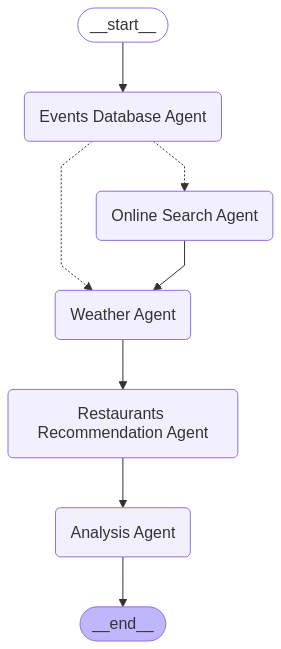

Graph built successfully
Starting to stream events through the workflow...

**************************************************
events_database_agent function called
**************************************************
Events set to: No upcoming events found for Tampa in local database.
Routing events. Current state: city='Tampa' messages=[{'role': 'user', 'content': "What's happening in Tampa and what should I wear?"}] events_result='No upcoming events found for Tampa in local database.' search_result='' weather_info={} analysis_result='' restaurant_recommendations=''
Events content: 'No upcoming events found for Tampa in local database.'
No events found in local DB. Routing to Online Search Agent.

Intermediate output: {'Events Database Agent': {'city': 'Tampa', 'messages': [{'role': 'user', 'content': "What's happening in Tampa and what should I wear?"}], 'events_result': 'No upcoming events found for Tampa in local database.', 'search_result': '', 'weather_info': {}, 'analysis_result'

In [111]:
if __name__ == "__main__":
    city = "Tampa"
    print(f"Starting script execution for city: {city}")
    main(city)

### Example 2: New York


Starting script execution for city: New York
Starting main execution for city: New York
Workflow compiled successfully


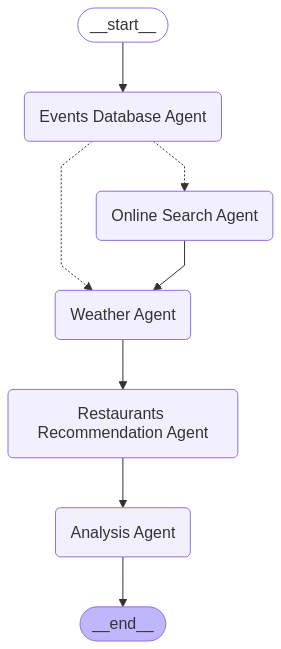

Graph built successfully
Starting to stream events through the workflow...

**************************************************
events_database_agent function called
**************************************************
Found 3 events for New York:
                    event_name event_date                                               description
         Tribeca Film Festival 2024-06-07            An annual film festival in Tribeca, Manhattan.
         New York Fashion Week 2024-09-05                   A semi-annual series of fashion events.
Macy's Thanksgiving Day Parade 2024-11-28 An annual parade presented by Macy's on Thanksgiving Day.
Events set to: • Tribeca Film Festival (2024-06-07): An annual film festival in Tribeca, Manhattan.
• New York Fashion Week (2024-09-05): A semi-annual series of fashion events.
• Macy's Thanksgiving Day Parade (2024-11-28): An annual parade presented by Macy's on Thanksgiving Day.
Routing events. Current state: city='New York' messages=[{'role': 'user'

In [ ]:
if __name__ == "__main__":
    city = "New York"
    print(f"Starting script execution for city: {city}")
    main(city)

### Example 3: Philadelphia, Pennsylvania


Starting script execution for city: Philadelphia
Starting main execution for city: Philadelphia
Workflow compiled successfully


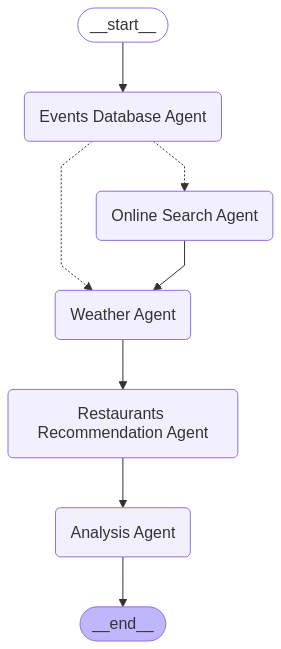

Graph built successfully
Starting to stream events through the workflow...

**************************************************
events_database_agent function called
**************************************************
Found 3 events for Philadelphia:
                event_name event_date                                                                                              description
  Philadelphia Flower Show 2024-03-02                             The world's largest indoor flower show, featuring elaborate garden displays.
      Wawa Welcome America 2024-06-28 A week-long festival celebrating Independence Day with concerts, fireworks, and historical reenactments.
Philadelphia Film Festival 2024-10-17                                  An annual film festival showcasing independent and international films.
Events set to: • Philadelphia Flower Show (2024-03-02): The world's largest indoor flower show, featuring elaborate garden displays.
• Wawa Welcome America (2024-06-28): A week-lo

In [ ]:
if __name__ == "__main__":
    city = "Philadelphia"
    print(f"Starting script execution for city: {city}")
    main(city)

### Analysis of Results

1. **Tampa, Florida**:
   - Events: Not found in the local database, triggering the search tool.
   - Weather: Retrieved from OpenWeatherMap API.
   - Restaurants: Recommendations provided through the RAG system.

2. **Philadelphia, Pennsylvania**:
   - Events: Found in the local database.
   - Weather: Retrieved from OpenWeatherMap API.
   - Restaurants: Recommendations provided through the RAG system.

3. **New York, New York**:
   - Events: Found in the local database.
   - Weather: Retrieved from OpenWeatherMap API.
   - Restaurants: No recommendations available in the RAG system.

#### Similarities:
- All three cases utilized the weather tool to fetch current weather information.
- The analysis node provided recommendations based on available data for each city.

#### Differences:
- Tampa required the use of the search tool for event information, while Philadelphia and New York used the local database.
- Philadelphia had both local event data and restaurant recommendations, providing the most comprehensive results.
- New York had local event data but lacked restaurant recommendations, showcasing the system's ability to work with partial information.

#### Key Observations:
1. The system adapts to available data sources, seamlessly switching between local and online searches for event information.
2. Weather information is consistently provided, forming a core part of the recommendations.
3. The RAG system for restaurant recommendations enhances the output when data is available but doesn't hinder the overall functionality when it's not.
4. The analysis node demonstrates flexibility in synthesizing varying levels of information to provide useful recommendations.

This multi-city comparison highlights the robustness and adaptability of our multi-agent system, showcasing its ability to provide valuable insights even when faced with varying levels of available information across different cities.



## Conclusion

This notebook demonstrates the power of multi-agent systems built with LangGraph and powered by Mistral. By combining various data sources and agents, we've created a comprehensive city information system that can provide valuable insights for users.

Our system successfully gathered and analyzed information about events, weather, activities, and dining options for the specified cities. This showcases the potential of using LangGraph to create complex, multi-step workflows that can process and synthesize information from various sources.

